In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

from utils import * 

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


In [2]:
def BuildConvolutionBlock(inp, filters_count):
    conv = Conv2D(filters_count[0], (3, 3), padding='same')(inp)
    conv = Activation('relu')(conv)
    
    for filter_count in filters_count[1:]:
        conv = Conv2D(filters_count[0], (3, 3), padding='same')(conv)
        conv = Activation('relu')(conv)
    
    return conv

def BuildModel_HRNet_without_cross():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_fs_1 = BuildConvolutionBlock(inp, [32, 32])
    conv_fs_2 = BuildConvolutionBlock(conv_fs_1, [64, 64])
    conv_fs_3 = BuildConvolutionBlock(conv_fs_2, [64, 64])
    conv_fs_4 = BuildConvolutionBlock(conv_fs_3, [64, 64])

    conv_fs_1_pool = MaxPooling2D(2)(conv_fs_1)
    conv_hs_1 = BuildConvolutionBlock(conv_fs_1_pool, [32, 32])
    conv_hs_2 = BuildConvolutionBlock(conv_hs_1, [64, 64])
    conv_hs_3 = BuildConvolutionBlock(conv_hs_2, [64, 64])
    conv_hs_3_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_3)

    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2)
    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2_pool)
    conv_hs_1_pool = MaxPooling2D(2)(conv_hs_1)
    conv_qs_1 = BuildConvolutionBlock(Concatenate()([conv_fs_2_pool, conv_hs_1_pool]), [32, 32])
    conv_qs_2 = BuildConvolutionBlock(conv_qs_1, [64, 64])
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2_up)
    
    
    concat = Concatenate()([conv_fs_4, conv_hs_3_up, conv_qs_2_up])
    conv_out_1 = Conv2D(64, (3, 3), padding='same')(concat)
    conv_out_1 = Activation('relu')(conv_out_1)
    conv_out_2 = Conv2D(4, (3, 3), padding='same')(conv_out_1)
    result = Activation('sigmoid')(conv_out_2)

    return Model(inputs=inp, outputs=result)

def BuildModel_HRNet_with_cross():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    # 1
    conv_fs_1 = BuildConvolutionBlock(inp, [32, 32])

    # 1 -> 2
    conv_fs_1_pool = MaxPooling2D(2)(conv_fs_1)
    
    # 2    
    conv_hs_1 = BuildConvolutionBlock(conv_fs_1_pool, [32, 32])    
    conv_fs_2 = BuildConvolutionBlock(conv_fs_1, [64, 64])
    
    # 2 -> 3
    conv_fs_2_pool = MaxPooling2D(2)(conv_fs_2)
    conv_fs_2_pool_2 = MaxPooling2D(2)(conv_fs_2_pool)
    conv_hs_1_pool = MaxPooling2D(2)(conv_hs_1)
    
    conv_hs_1_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_1)
    
    # 3    
    conv_fs_3 = BuildConvolutionBlock(Concatenate()([conv_hs_1_up, conv_fs_2]), [64, 64])
    conv_hs_2 = BuildConvolutionBlock(Concatenate()([conv_hs_1, conv_fs_2_pool]), [64, 64])
    conv_qs_1 = BuildConvolutionBlock(Concatenate()([conv_fs_2_pool_2, conv_hs_1_pool]), [32, 32])
    
    # 3 -> 4
    conv_fs_3_pool = MaxPooling2D(2)(conv_fs_3)
    conv_fs_3_pool_2 = MaxPooling2D(2)(conv_fs_3_pool)
    conv_hs_2_pool = MaxPooling2D(2)(conv_hs_2)
    
    conv_hs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_2)
    conv_qs_1_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_1)
    conv_qs_1_up_2 = UpSampling2D(2, interpolation='bilinear')(conv_qs_1_up)
    
    # 4
    conv_fs_4 = BuildConvolutionBlock(Concatenate()([conv_fs_3, conv_hs_2_up, conv_qs_1_up_2]), [64, 64])
    conv_hs_3 = BuildConvolutionBlock(Concatenate()([conv_hs_2, conv_qs_1_up, conv_fs_3_pool]), [64, 64])
    conv_qs_2 = BuildConvolutionBlock(Concatenate()([conv_qs_1, conv_fs_3_pool_2, conv_hs_2_pool]), [64, 64])    
    
    # 4 -> out
    conv_hs_3_up = UpSampling2D(2, interpolation='bilinear')(conv_hs_3)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2)
    conv_qs_2_up = UpSampling2D(2, interpolation='bilinear')(conv_qs_2_up)
    
    # out
    concat = Concatenate()([conv_fs_4, conv_hs_3_up, conv_qs_2_up])
    conv_out_1 = Conv2D(64, (3, 3), padding='same')(concat)
    conv_out_1 = Activation('relu')(conv_out_1)
    conv_out_2 = Conv2D(4, (3, 3), padding='same')(conv_out_1)
    result = Activation('sigmoid')(conv_out_2)

    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('hrnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('hrnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_HRNet_without_cross()
# model = BuildModel_HRNet_with_cross()

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		10000
Number of files in Validation-set:	2000


In [4]:
batch_size = 16

steps_per_epoch = 200
epochs_count = 25
validation_steps = steps_per_epoch // 4

history = model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=epochs_count,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=validation_steps,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
200/200 [==============================] - 84s 422ms/step - loss: 0.5677 - val_loss: 0.3220
Epoch 2/25
200/200 [==============================] - 82s 409ms/step - loss: 0.2995 - val_loss: 0.2356
Epoch 3/25
200/200 [==============================] - 82s 410ms/step - loss: 0.2347 - val_loss: 0.2567
Epoch 4/25
200/200 [==============================] - 82s 410ms/step - loss: 0.2213 - val_loss: 0.1489
Epoch 5/25
200/200 [==============================] - 82s 410ms/step - loss: 0.2161 - val_loss: 0.1675
Epoch 6/25
200/200 [==============================] - 82s 410ms/step - loss: 0.1981 - val_loss: 0.1784
Epoch 7/25
200/200 [==============================] - 82s 410ms/step - loss: 0.1899 - val_loss: 0.1843
Epoch 8/25
200/200 [==============================] - 82s 410ms/step - loss: 0.1988 - val_loss: 0.2226
Epoch 9/25
200/200 [==============================] - 82s 410ms/step - loss: 0.1838 - val_loss: 0.1285
Epoch 10/25
200/200 [====

dict_keys(['val_loss', 'loss'])


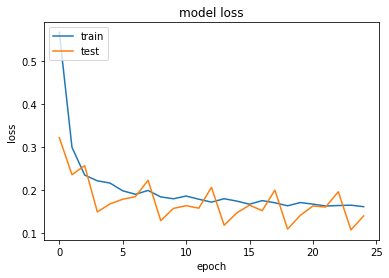

In [5]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [6]:
model = None
from keras.models import load_model
model1 = load_model('hrnet_best.h5')

In [7]:
testing_batch_size = 16
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, testing_batch_size):
    break

In [8]:
pred = model1.predict(x)

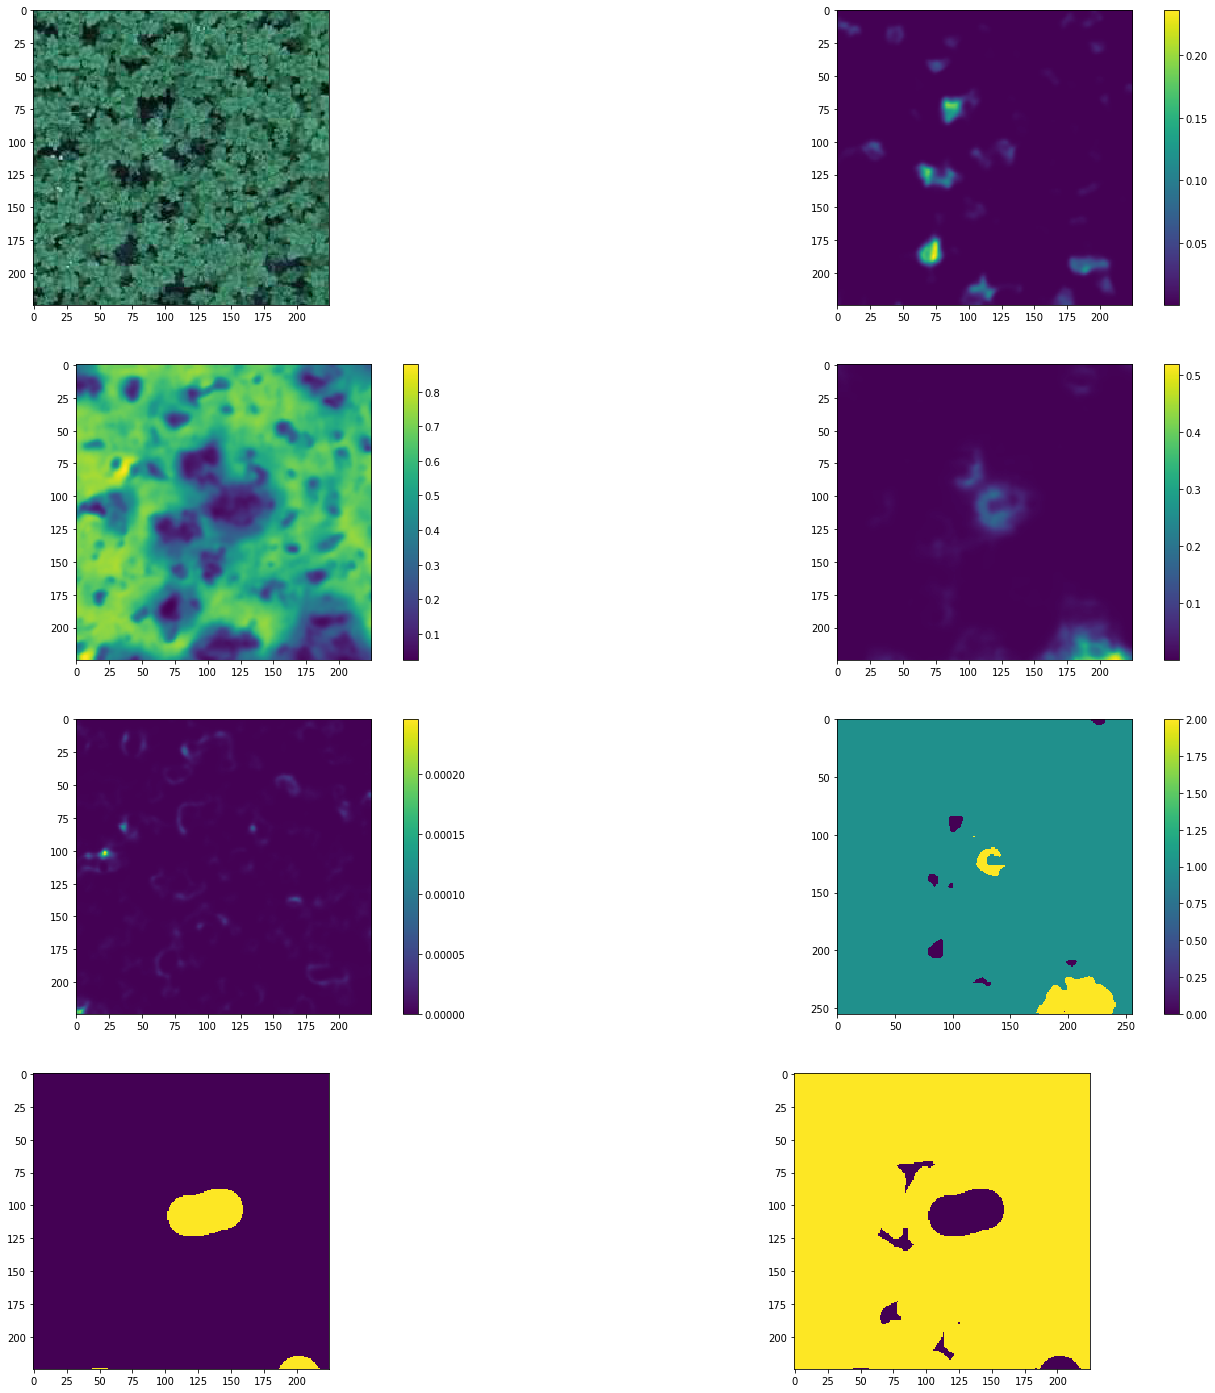

In [9]:
sample_index = 1
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index, 15:240, 15:240, :])
im_0_1 = axes[0][1].imshow(pred[sample_index, 15:240, 15:240, 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, 15:240, 15:240, 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, 15:240, 15:240, 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, 15:240, 15:240, 3])
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
im_3_0 = axes[3][0].imshow(y[sample_index, 15:240, 15:240, 2])
im_3_1 = axes[3][1].imshow(y[sample_index, 15:240, 15:240, 1])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [10]:
CountErrors(y[sample_index], pred[sample_index]) 

(61781,
 {0: 1083, 1: 60849, 2: 3604, 3: 0},
 {0: [368, 0, 0, 0], 1: [0, 60084, 0, 0], 2: [0, 0, 1329, 0], 3: [0, 0, 0, 0]},
 {0: [0, 713, 2, 0], 1: [161, 0, 604, 0], 2: [1, 2274, 0, 0], 3: [0, 0, 0, 0]})

In [11]:
sample_index = 2

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])       

In [12]:
ok_cnt, required, valid, errors

(63527,
 {0: 1832, 1: 62104, 2: 1600, 3: 0},
 {0: [374, 0, 0, 0], 1: [0, 61955, 0, 0], 2: [0, 0, 1198, 0], 3: [0, 0, 0, 0]},
 {0: [0, 1451, 7, 0], 1: [16, 0, 133, 0], 2: [0, 402, 0, 0], 3: [0, 0, 0, 0]})

In [13]:
sample_index = 5

ok_cnt, required, valid, errors = CountErrors(y[sample_index], pred[sample_index])   

In [14]:
ok_cnt, required, valid, errors

(57505,
 {0: 3198, 1: 47112, 2: 15226, 3: 0},
 {0: [2079, 0, 0, 0],
  1: [0, 46343, 0, 0],
  2: [0, 0, 9083, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 873, 246, 0],
  1: [95, 0, 674, 0],
  2: [237, 5906, 0, 0],
  3: [0, 0, 0, 0]})

### Image by image segmentation

In [15]:
img_name = './for_manual_tests/sample_38.png'
mask_name = './for_manual_tests/sample_38_mask.png'
x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)

In [16]:
pred = model1.predict(x)

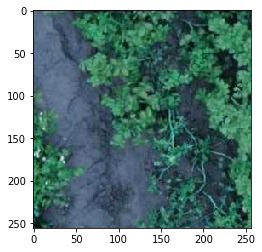

In [17]:
plt.imshow(x[0])

True

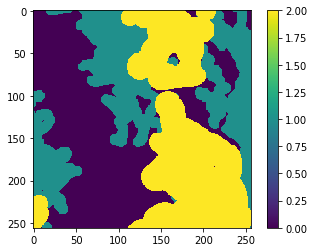

In [18]:
im_0_1 = plt.imshow(getClassesMap(y[0]))
plt.colorbar(im_0_1)

img = (getClassesMap(y[0]) * 255. / 3).astype(np.uint8)
cv2.imwrite("sample_mask_gray.png", img)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_mask.png", img)

In [19]:
np.min(pred[0, ..., 1]),np.max(pred[0, ..., 1]), pred.shape

(3.0457973e-05, 0.6192847, (1, 256, 256, 4))

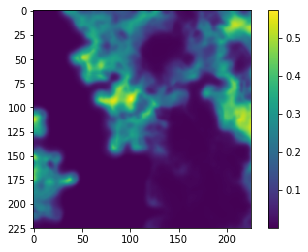

In [20]:
channel = 1

# print(np.min(pred[0, ..., channel]))
# print(np.max(pred[0, ..., channel]))

min_val = np.min(pred[0, ..., channel])
max_val = np.max(pred[0, ..., channel])

# print(0.5 * (min_val + max_val))

a = (pred[0, 15:240, 15:240, channel] - min_val) / (max_val - min_val)
# print(np.min(a))
# print(np.max(a))

im_0_1 = plt.imshow(pred[0, 15:240, 15:240, channel])
plt.colorbar(im_0_1)

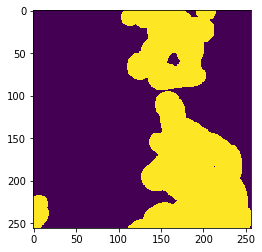

In [21]:
plt.imshow(y[0, ..., 2])

True

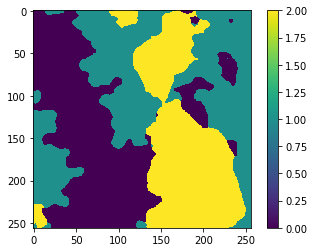

In [22]:
im_0_1 = plt.imshow(getClassesMap(pred[0]))
plt.colorbar(im_0_1)

img = (getClassesMap(pred[0]) * 255. / 3).astype(np.uint8)
cv2.imwrite("sample_hrnet_gray.png", img)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
cv2.imwrite("sample_hrnet.png", img)

In [23]:
sum(sum(getClassesMap(pred)))

29184

In [24]:
pred = model1.predict(x)

In [25]:
ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 

In [26]:
ok_cnt, required, valid, errors

(56673,
 {0: 24071, 1: 19429, 2: 22036, 3: 0},
 {0: [21295, 0, 0, 0],
  1: [0, 18025, 0, 0],
  2: [0, 0, 17353, 0],
  3: [0, 0, 0, 0]},
 {0: [0, 2144, 632, 0],
  1: [724, 0, 680, 0],
  2: [790, 3893, 0, 0],
  3: [0, 0, 0, 0]})

### Estimate accuracy for validation set

In [27]:
all_ok_cnt = 0
all_required = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
}
all_valid = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
all_errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}

for i in tqdm(range(len(data.valid.image_paths))):
    img_name = data.valid.image_paths[i]
    mask_name = data.valid.masks_paths[i]
    
    x,y = prepare_image_and_mask_for_prediction(img_name, mask_name)
    
    pred = model1.predict(x)
#     pred[:,:,:,2] *= 2
    
    ok_cnt, required, valid, errors = CountErrors(y[0], pred[0]) 
    
    all_ok_cnt += ok_cnt
    for j in range(4):
        all_required[j] = all_required[j] + required[j]
        all_valid[j] = [x + y for x, y in zip(all_valid[j], valid[j])]
        all_errors[j] = [x + y for x, y in zip(all_errors[j], errors[j])]

image_area = params.GetImageSize() * params.GetImageSize()
image_cnt = len(data.valid.image_paths)
scale = float(image_area * image_cnt) / 100.

all_ok_cnt /= scale
for j in range(4):
    all_required[j] /= scale
    all_valid[j] = [x / scale for x in all_valid[j]]
    all_errors[j] = [x / scale for x in all_errors[j]]

In [28]:
all_ok_cnt, all_required, all_valid, all_errors

(93.84098892211914,
 {0: 12.87076644897461,
  1: 78.43060760498047,
  2: 8.233311462402344,
  3: 0.4653144836425781},
 {0: [11.081318664550782, 0.0, 0.0, 0.0],
  1: [0.0, 77.05592346191406, 0.0, 0.0],
  2: [0.0, 0.0, 5.298625183105469, 0.0],
  3: [0.0, 0.0, 0.0, 0.4051216125488281]},
 {0: [0.0, 1.567828369140625, 0.20579452514648439, 0.01582489013671875],
  1: [0.6155433654785156, 0.0, 0.7338356018066406, 0.02530517578125],
  2: [0.23878021240234376, 2.695893096923828, 0.0, 1.2969970703125e-05],
  3: [0.02211761474609375, 0.038042449951171876, 3.2806396484375e-05, 0.0]})

In [29]:
confusion_matrix = np.zeros([4,4])
for x in range(4):
    confusion_matrix[x,x] = all_valid[x][x]

for real_class in range(4):
    for predicted_class in range(4):
        if real_class == predicted_class:
            continue
        confusion_matrix[predicted_class,real_class] = all_errors[real_class][predicted_class]

precision = np.zeros([4])
for i in range(4):
    precision[i] = confusion_matrix[i,i] / sum(confusion_matrix[i,:])
    
recall = np.zeros([4])
for i in range(4):
    recall[i] = confusion_matrix[i,i] / sum(confusion_matrix[:,i])
        
def CalcF(precisionV, recallV):
    return 2 * precisionV * recallV / (precisionV + recallV)

F = [ CalcF(precisionV, recallV) for precisionV, recallV in zip(precision, recall) ]
F = np.array(F)

confusion_matrix, precision, recall, F
np.set_printoptions(precision=2)
np.set_printoptions(formatter={"float_kind": lambda x: "%0.2f" % x})

print("confusion_matrix = \n{}".format(confusion_matrix))
print("precision = {}".format(precision))
print("recall = {}".format(recall))
print("F = {}".format(F))

confusion_matrix = 
[[11.08 0.62 0.24 0.02]
 [1.57 77.06 2.70 0.04]
 [0.21 0.73 5.30 0.00]
 [0.02 0.03 0.00 0.41]]
precision = [0.93 0.95 0.85 0.91]
recall = [0.86 0.98 0.64 0.87]
F = [0.89 0.96 0.73 0.89]
